In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

In [2]:
os.getcwd()

'/home/fouriest/SCHOOL/Princeton/PPPL/DESC/local'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from scipy.constants import mu_0
import desc
from desc.coils import CoilSet
from desc.magnetic_fields import (
    SplineMagneticField,
    field_line_integrate,
    FourierCurrentPotentialField,
)
from desc.profiles import PowerSeriesProfile
from desc.grid import LinearGrid
from desc.geometry import FourierRZToroidalSurface
from desc.equilibrium import Equilibrium, EquilibriaFamily
from desc.magnetic_fields import FourierCurrentPotentialField, ToroidalMagneticField
from desc.objectives import (
    FixBoundaryR,
    FixBoundaryZ,
    FixIota,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
)

from desc.optimize import Optimizer
from desc.vmec import VMECIO

DESC version 0.10.4+602.g22e926004,using JAX backend, jax version=0.4.13, jaxlib version=0.4.13, dtype=float64
Using device: CPU, with 11.61 GB available memory


In [4]:
eqf1 = desc.io.load("precise_QA_AL.h5")
eqf2 = desc.io.load("precise_QA_AL_well.h5")
eqf3 = desc.io.load("precise_QA_AL_well2.h5")

ncsx = desc.examples.get("NCSX")
estell = desc.examples.get("ESTELL")

/home/fouriest/SCHOOL/Princeton/PPPL/DESC/desc/io/hdf5_io.py:125: RuntimeWarning: Save attribute '_shift' was not loaded.
  warnings.warn(
/home/fouriest/SCHOOL/Princeton/PPPL/DESC/desc/io/hdf5_io.py:125: RuntimeWarning: Save attribute '_rotmat' was not loaded.
  warnings.warn(
/home/fouriest/SCHOOL/Princeton/PPPL/DESC/desc/io/hdf5_io.py:125: RuntimeWarning: Save attribute '_rho' was not loaded.
  warnings.warn(
/home/fouriest/SCHOOL/Princeton/PPPL/DESC/desc/io/hdf5_io.py:125: RuntimeWarning: Save attribute '_anisotropy' was not loaded.
  warnings.warn(


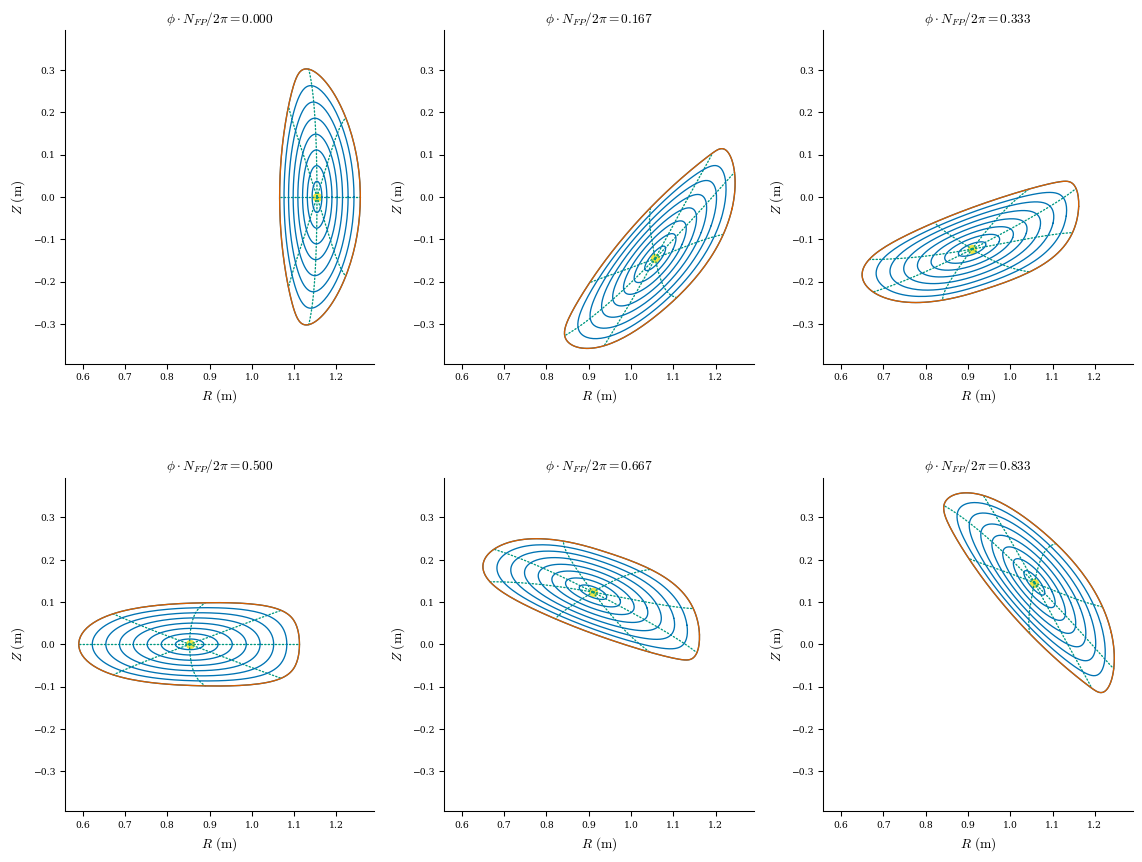

In [68]:
desc.plotting.plot_surfaces(eqf1[-1]);

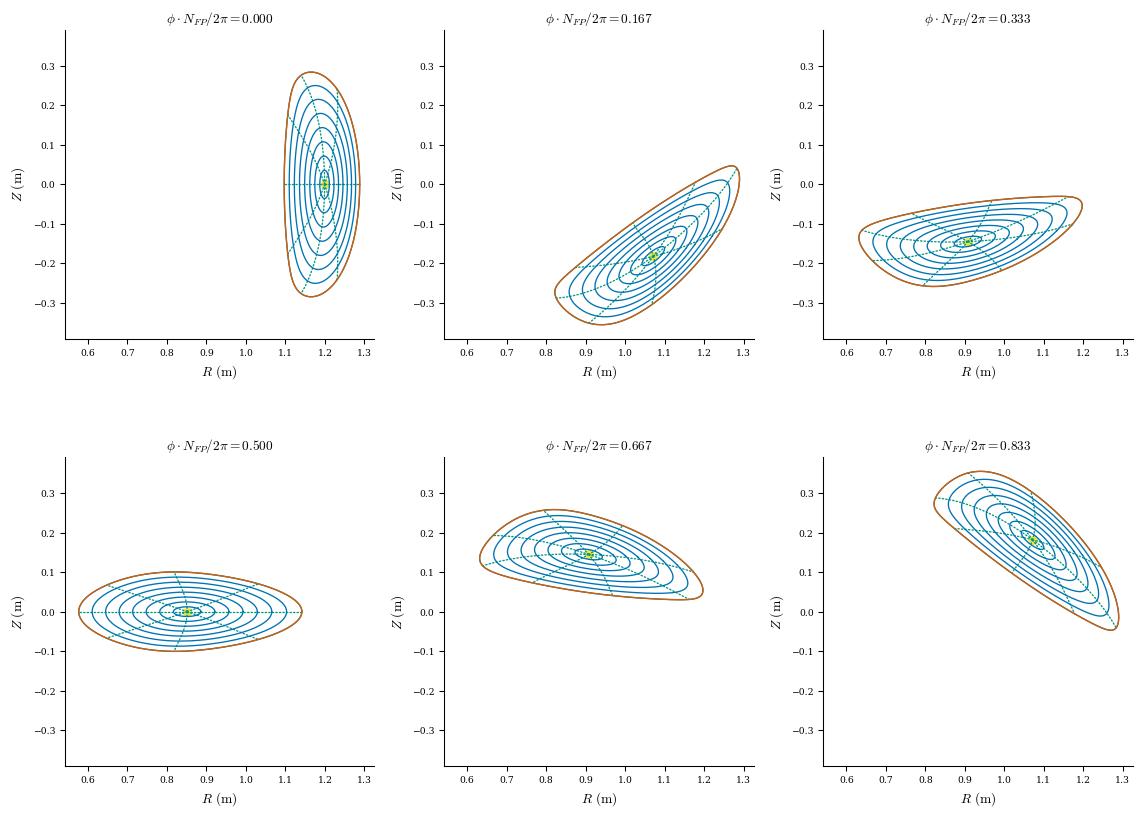

In [69]:
desc.plotting.plot_surfaces(eqf2[-1]);

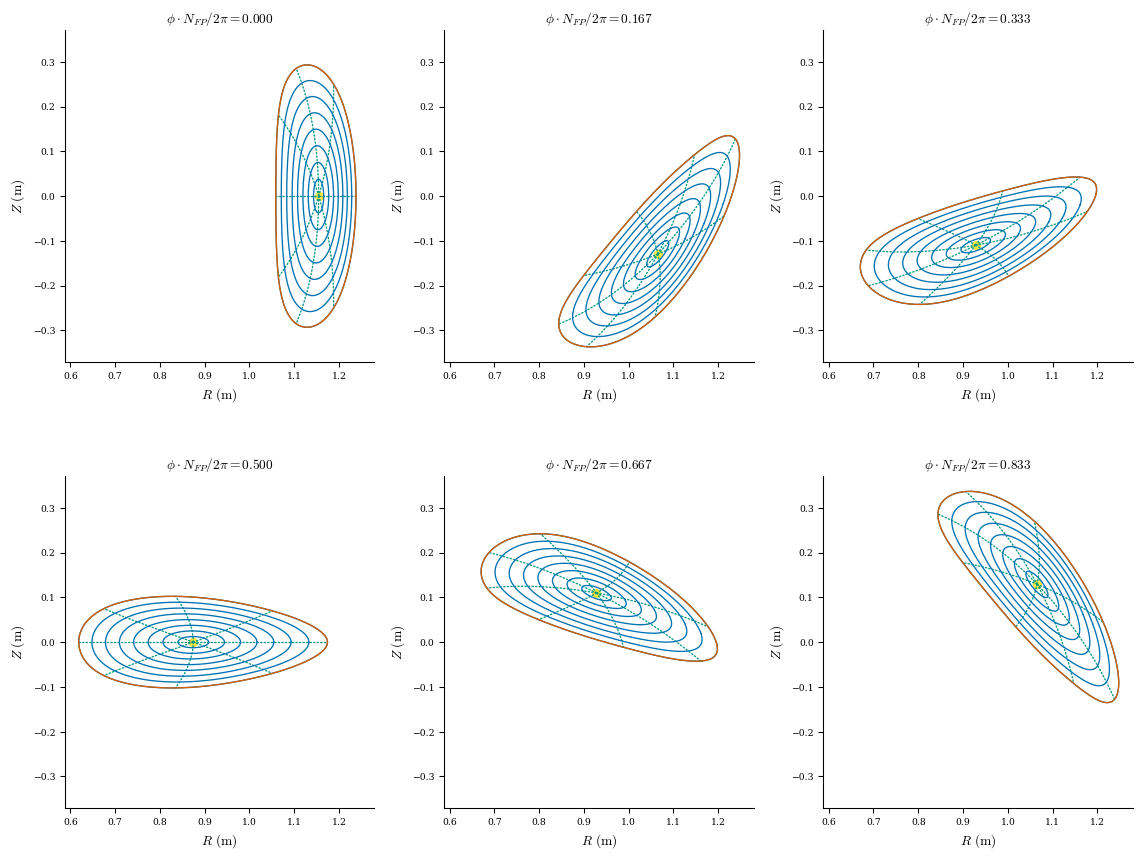

In [70]:
desc.plotting.plot_surfaces(eqf3[-1]);

(<Figure size 384x384 with 1 Axes>,
 <Axes: xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>)

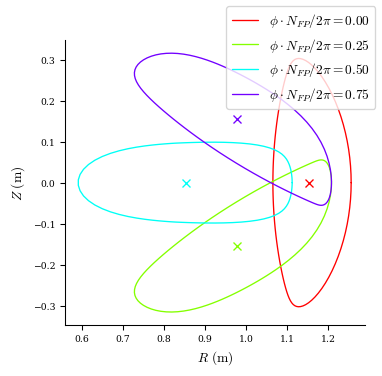

In [5]:
desc.plotting.plot_boundary(eqf1[-1], figsize=(4, 4))

(<Figure size 384x384 with 1 Axes>,
 <Axes: xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>)

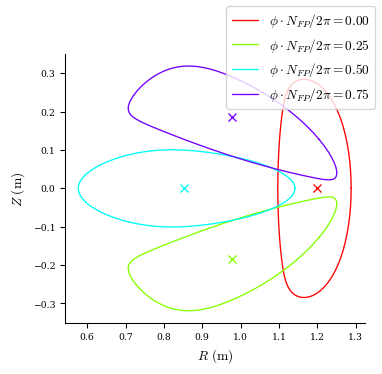

In [6]:
desc.plotting.plot_boundary(eqf2[-1], figsize=(4, 4))

(<Figure size 384x384 with 1 Axes>,
 <Axes: xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>)

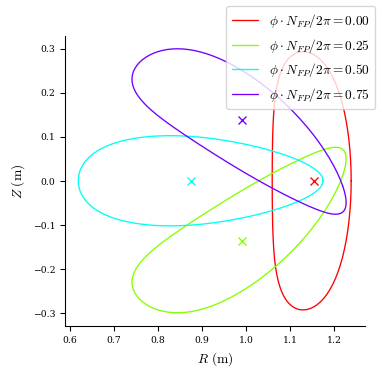

In [7]:
desc.plotting.plot_boundary(eqf3[-1], figsize=(4, 4))

(<Figure size 384x384 with 1 Axes>,
 <Axes: xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>)

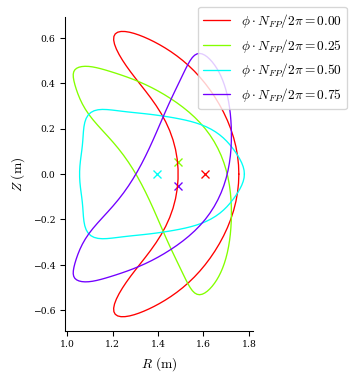

In [8]:
desc.plotting.plot_boundary(ncsx, figsize=(4, 4))

In [ ]:
eqs = {
    "Curvature constrained": eqf1[-1],
    "Curvature constrained + well": eqf2[-1],
    "Curvature constrained + well2": eqf3[-1],
    "NCSX": ncsx,
}

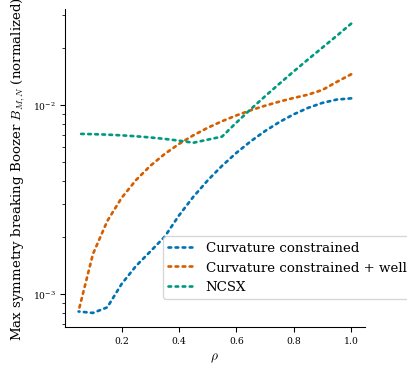

In [15]:
fig, ax = plt.subplots(figsize=(4, 4))

from desc.plotting import colorblind_colors

fig, ax = desc.plotting.plot_boozer_modes(
    eqf1[-1],
    log=True,
    B0=False,
    norm=True,
    max_only=True,
    helicity=(1, 0),
    ax=ax,
    label="Curvature constrained",
    ls=":",
    color=colorblind_colors[0],
    legend=False,
)


fig, ax = desc.plotting.plot_boozer_modes(
    eqf3[-1],
    log=True,
    B0=False,
    norm=True,
    max_only=True,
    helicity=(1, 0),
    ax=ax,
    label="Curvature constrained + well",
    ls=":",
    color=colorblind_colors[1],
    legend=False,
)

fig, ax = desc.plotting.plot_boozer_modes(
    ncsx,
    log=True,
    B0=False,
    norm=True,
    max_only=True,
    helicity=(1, 0),
    ax=ax,
    label="NCSX",
    ls=":",
    color=colorblind_colors[2],
    legend=False,
)


fig.legend(loc=(0.4, 0.2))

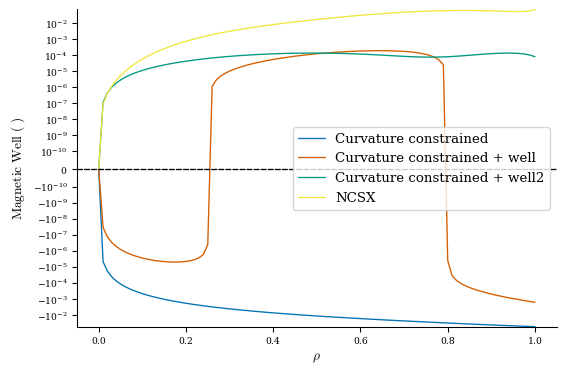

In [77]:
fig, ax = plt.subplots()
for i, (name, eq) in enumerate(eqs.items()):

    fig, ax = desc.plotting.plot_1d(
        eq,
        "magnetic well",
        ax=ax,
        label=name,
        linecolor=colorblind_colors[i],
    )
ax.axhline(0, c="k", ls="--")
ax.set_yscale("symlog", linthresh=1e-10)
ax.legend()

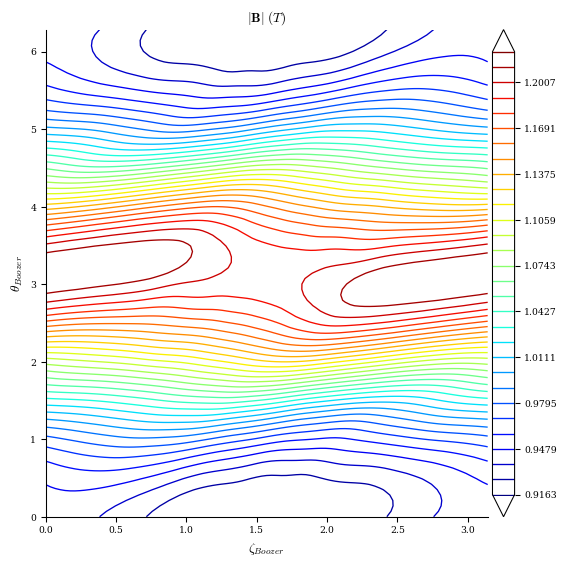

In [84]:
desc.plotting.plot_boozer_surface(eqf1[-1]);

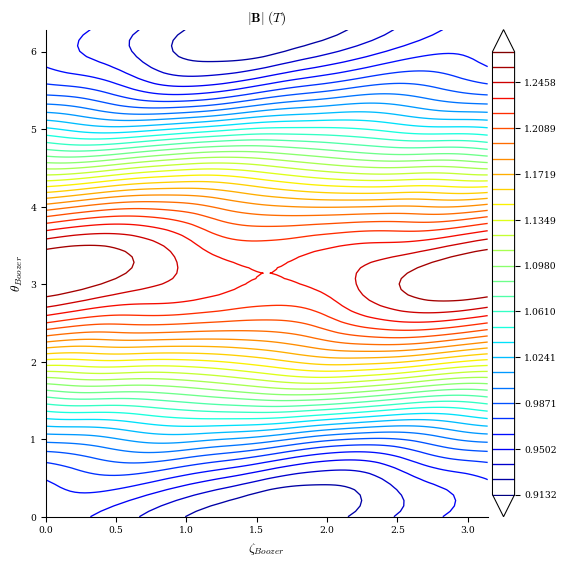

In [85]:
desc.plotting.plot_boozer_surface(eqf2[-1]);

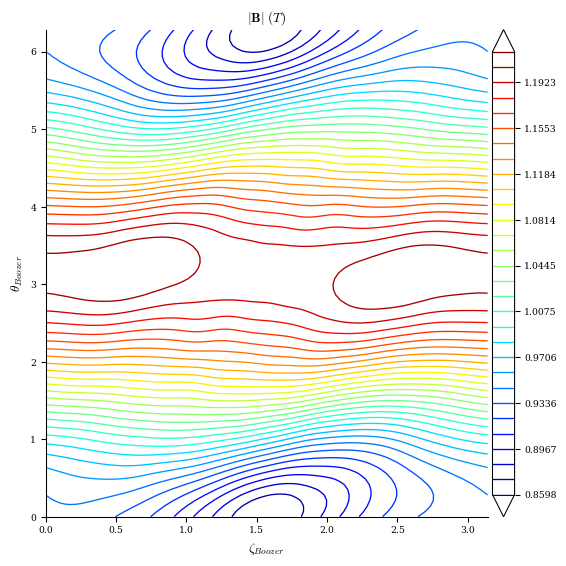

In [86]:
desc.plotting.plot_boozer_surface(eqf3[-1]);

# Lagrange Multipliers

In [78]:
eq = eqf2[-1]
grid = LinearGrid(M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, sym=eq.sym)

In [79]:
import pickle

with open("precise_QA_AL_well.pkl", "rb") as f:
    out = pickle.load(f)

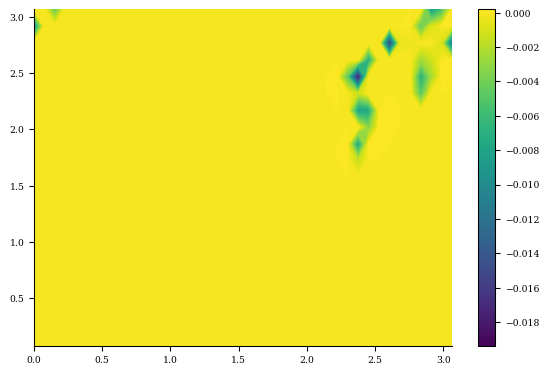

In [80]:
y_curv = out["y"][-grid.num_nodes :]
v_curv = out["v"][-grid.num_nodes :]

y_well = out["y"][-grid.num_nodes - eq.L_grid : -grid.num_nodes]
v_well = out["v"][-grid.num_nodes - eq.L_grid : -grid.num_nodes]

v_curv = np.where(v_curv < 1e-2, 1, 0)
v_well = np.where(v_well < 1e-2, 1, 0)

d_curv = y_curv * v_curv
fig, ax = plt.subplots()
im = ax.contourf(
    grid.nodes[grid.unique_zeta_idx, 2],
    grid.nodes[grid.unique_theta_idx, 1],
    d_curv.reshape((grid.num_theta, grid.num_rho, grid.num_zeta), order="F").squeeze(),
    levels=100,
)
fig.colorbar(im)

In [81]:
grid1 = LinearGrid(M=eq.M_grid, N=eq.N_grid, NFP=1, sym=False, endpoint=True)
data = eq.compute(["X", "Y", "Z"], grid=grid1)

/home/fouriest/SCHOOL/Princeton/PPPL/DESC/desc/transform.py:69: UserWarning:

Unequal number of field periods for grid 1 and basis 2.

/home/fouriest/SCHOOL/Princeton/PPPL/DESC/desc/transform.py:69: UserWarning:

Unequal number of field periods for grid 1 and basis 2.



In [82]:
# stellarator symmetry and 2 field periods
d_curv1 = np.vstack(
    [
        d_curv.reshape(
            (grid.num_theta, grid.num_rho, grid.num_zeta), order="F"
        ).squeeze(),
        d_curv.reshape(
            (grid.num_theta, grid.num_rho, grid.num_zeta), order="F"
        ).squeeze()[::-1, ::-1],
    ]
)
d_curv1 = np.hstack([d_curv1, d_curv1])

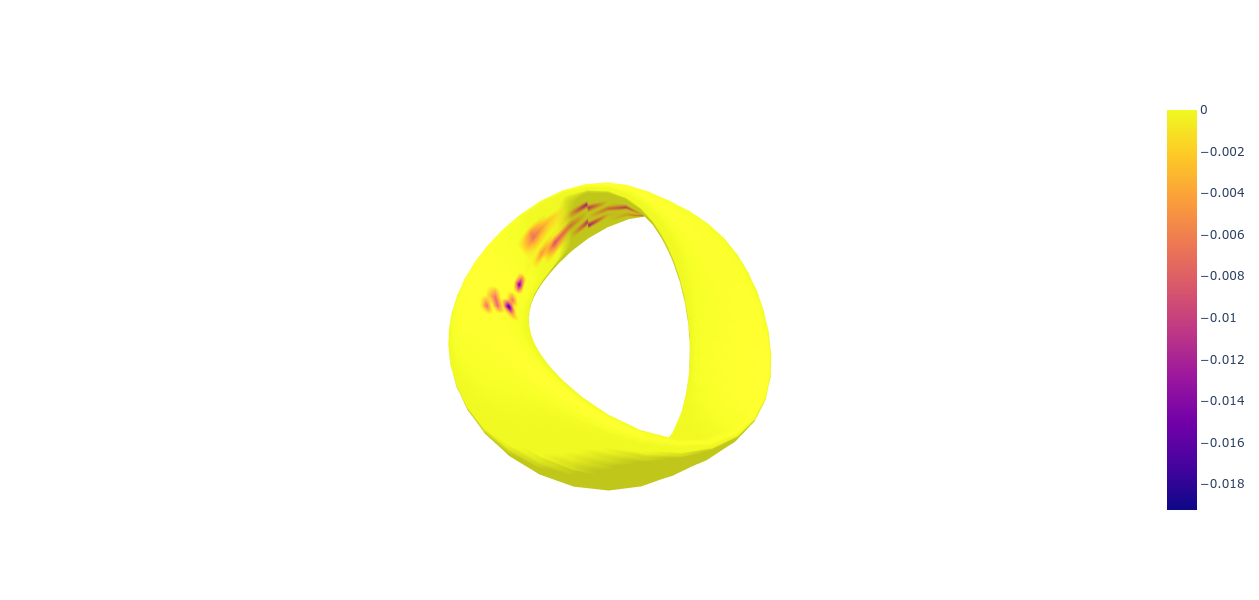

In [83]:
import plotly
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Surface(
        x=data["X"]
        .reshape((grid1.num_theta, grid1.num_rho, grid1.num_zeta), order="F")
        .squeeze(),
        y=data["Y"]
        .reshape((grid1.num_theta, grid1.num_rho, grid1.num_zeta), order="F")
        .squeeze(),
        z=data["Z"]
        .reshape((grid1.num_theta, grid1.num_rho, grid1.num_zeta), order="F")
        .squeeze(),
        surfacecolor=d_curv1,
    )
)
fig.update_layout(
    scene=dict(
        aspectmode="data",
        xaxis=dict(
            backgroundcolor="white",
            gridcolor="white",
            showbackground=False,
            zerolinecolor="white",
            visible=False,
        ),
        yaxis=dict(
            backgroundcolor="white",
            gridcolor="white",
            showbackground=False,
            zerolinecolor="white",
            visible=False,
        ),
        zaxis=dict(
            backgroundcolor="white",
            gridcolor="white",
            showbackground=False,
            zerolinecolor="white",
            visible=False,
        ),
    ),
    width=600,
    height=600,
)

fig.show()